# **The Subscriber Segmenteer**
by [Andrew Yu](https://www.linkedin.com/in/andrewdyu/), [Norman Chen](https://www.linkedin.com/in/naiming-chen/), and [Cathy Chen](https://www.linkedin.com/in/cathy-chen-8b5480195/).

---

Check it out on [GitHub](https://github.com/YuDrew/strategic-subscriber-segmentation/).



# **Executive Summary**
---

## **Background & Objective**

In the space of content creation, subscribers rule above all else. With the release of new publishing platforms like Anchor (podcasts) and Substack (newsletters), a new wave of content creators is starting to emerge. As content niches mature, content creators will need to more heavily compete for advertisement deals and sponsorships, and in order to do so, it is imperative that they understand who their subscribers are. However, these new publishing platforms aren’t equipped with the right tools to help creators properly break down their audience by increasingly niche segmentation criteria. This makes it hard for creators to curate good content for their audience, and it’s doubly difficult to secure advertisement deals if they can only guess at their audience base. 

We hope to build the Startup Sub Sifter: a scalable model that can quickly and accurately categorize subscribers of entrepreneurship-focused content into useful categories (e.g.  investors vs startup operators vs students). Ideally, this tool should be:

1. cost-free considering that many creators are not yet monetized
2. relatively accurate and granular, and
3. repeatable OR continuously and automatically updated.

## **Data**

To build this model, we used a redacted subscriber snapshot of [Climate Tech VC](https://climatetechvc.substack.com/), a rapidly-growing Substack newsletter focused on climate innovation. The starting dataset consists 8662 website URLs and can be found [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/subscriber_websites.csv).

In order to transform this data into meaningful information,we pulled the text from the homepage of each website. The results of the initial scrape and cleaning can be found [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/scraped_website_text.csv).

After processing this scraped data, we end with a dataset of all subscribers with English websites and the plaintext from their website's homepage, which can be found [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/english_cleaned_all.csv).

## **Findings**

For our applications, K-means clustering actually offers a very powerful tool for customer segmentation. A simple Term Frequency, Inverse Document Frequency (TF-IDF) transformation provides ample information to meaningfully cluster our documents. 

The LDA topic modeling was able to provide similarly salient segments, but because LDA is a more complex model than K-Means, we find that the simpler solution is likely the better solution.

---

# Part 0: Notebook Setup
---

In [ ]:
%%capture
!pip install --upgrade gspread
!pip install flashtext
!pip install lxml
!pip install beautifulsoup4
!pip install htmlmetadata
!pip install -U gensim
!pip install pyldavis==2.1.2
!pip install requests_html

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%%capture
# Important Data Libs
import pandas as pd
import numpy as np

import os

# Important Viz Libs
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Text Processsing
import re

# LDA Topic Modeling
from gensim import corpora
from gensim import matutils
from gensim.models import LsiModel, KeyedVectors, LdaModel
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf
from gensim.models import HdpModel

# LDA Visualization
import pyLDAvis

# Important Export Libs
import gspread

# Part 1: Initial Data, Processing, & EDA
---


## 1.1 Starting with Websites

As previously mentioned, content creators often only have the list of emails for their audience (e.g. through their mailing list), plus a few additional fields that they may or may not have included in their audience onboarding process. 

For this exploration, we'll use a snapshot of the subscriber base of a Substack newsletter focused on climate tech. We've already exported this data, so we'll need to load it in via Google Drive.

In [ ]:
websites_df = pd.read_csv('https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/subscriber_websites.csv')
websites_df

,Website
0,cornell.edu
1,gmail.com
2,ida.ie
3,tolacapital.com
4,hearst.com
...,...
8657,gmail.com
8658,yale.edu
8659,gmail.com
8660,gmail.com


Taking a look at our data, it's clear that there are two big issues: 
1. Domain names alone isn't very much data to analyze, and segmentation would likely be very difficult. 
2. There are several "repeats" of websites in the data.
To see the extent of these repeats, let's take a look at the frequencies of these websites.

In [ ]:
website_frequencies = websites_df['Website'].value_counts()
website_frequencies

gmail.com              3713
hotmail.com             127
yahoo.com               124
stanford.edu             63
brown.edu                57
                       ... 
poundstone.co             1
MetroPolder.com           1
nd.edu                    1
octopusventures.com       1
chandaria.me              1
Name: Website, Length: 2840, dtype: int64

In [ ]:
# Important Data Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

# Let's make our data vis look better
plt.rc('figure',figsize=(17,13)) # Make our plots nice and big
plt.rc("font", size=14) # Make our fonts nice and big too
sns.set_style('darkgrid') # who doesn't like a dark theme
sns.set_color_codes('dark') # once again, dark themes rule

We have a lot of repeats in this subscriber list! We don't want to have to parse each of these multiple times, so let's get unique ones, only.

In [ ]:
unique_sites_df = pd.DataFrame(websites_df.Website.unique(), columns=['url'])
unique_sites_df

,url
0,cornell.edu
1,gmail.com
2,ida.ie
3,tolacapital.com
4,hearst.com
...,...
2835,corpgov.net
2836,knoweatall.co
2837,petri.bio
2838,climatescape.org


## 1.2 Getting More Data

In order to make meaningful customer clusters, we need more data. The only data we have access to is this list of websites - from here we can take only a handful of approaches.
1. If we know there's a comprehensive database of websites and classficiations, we could directly query that database. 
2. If we can't find or access such a database, we can instead go directly to the website and extract more information from each website. 

Because we don't have access to Option 1, we instead chose Option 2: scraping text from all the websites.

**Note**: Because scraping takes such a long time, especially with larger datasets, we've omitted the scraping from this notebook and instead have exported the results of our initial scrape and preprocessing [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/scraped_website_text.csv). We've instead opted to outline our process for the scrape in text.

### 1.2.1 Initial Scrape

In order to create meaningful data out of website URLs, we scraped plaintext from each website using the requests package, and we cleaned the data using the BeautifulSoup4 package. To speed up processes, we multithreaded our scrape.

```python
import requests
from bs4 import BeautifulSoup
import htmlmetadata
from htmlmetadata import extract_metadata
from lxml import html
from requests_html import HTMLSession
import concurrent.futures
import time

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
MAX_THREADS = 1000
```

The first function makes helps us get the strings from an HTML document.

```python
# Clean up Data with BeautifulSoup4
# @param html_code is a byte-type html document, generated typically by a requests.content call.
# @returns a list of "stripped strings"; BeautifulSoup4 separates out HTML code into different tags, and the text is extracted from each tag.
def get_strips(html_code):
  soup = BeautifulSoup(html_code, 'lxml')

  for script in soup(['script','style']):
      script.decompose()
        
  strips = list(soup.stripped_strings)
  return strips

```

The second function calls the actual request to get data from the website.

```python
# Scrape data from a given site. 
# @param site is the URL of the website to be scraped, ind is the index of the site in relation to the dataframe that this function is called on
# @return a whole host of data scraped from the website, including error logging, metadata description, metadata language category, and the "strips." 
def scrape_site(site, ind):
  print(site)
  
  # Generate potential URLs to loop through
  url_starts = ['https://', 'http://', 'https://www.', 'http://www.']
  urls = [start + site for start in url_starts]

  # Define Return Variables
  meta_description = ''
  meta_language = ''
  html_code = ''
  strips = []
  errors = []

  for url in urls:
    try:
      page = requests.get(url, timeout = 5, headers = headers)
      meta = extract_metadata(url)
      meta_description = meta['summary'].get('description')
      meta_language = meta['summary'].get('language')
      html_code = page.content
      strips = get_strips(html_code)
      break
    except Exception as exc:
      errors.append(exc)
  return meta_description, meta_language, str(html_code), strips, errors, ind

```

And this third function allows us to concurrently run the first two functions on every website in a dataframe.

```python
# Concurrently call scrape_site on all sites across a dataframe
#@param a dataframe that has been properly set up with error, description, language, html_code, and strips columns.
#@return a dataframe populated by all site scrapes.
def scrape_all_sites(df):
  with concurrent.futures.ThreadPoolExecutor(max_workers = MAX_THREADS) as executor:
    future_load_site = {executor.submit(scrape_site, df['url'][ind], ind): ind for ind in df.index}
    for future in concurrent.futures.as_completed(future_load_site):
        url = future_load_site[future]
        try:
          meta_description, meta_language, html_code, strips, errors, ind = future.result()
          df['description'][ind] = meta_description
          df['language'][ind] = meta_language
          df['html_code'] = html_code
          df['strips'][ind] = strips
        except Exception as exc:
          df['error'][ind].append(exc)
  return df
```

### 1.2.2 Initial Preprocessing



Once the data was consolidated into a dataframe, `processing_df`, we did basic regular expression extraction to start the preprocessing.

```python
# Scrape the Sites
processing_df = scrape_all_sites(websites_df)

# Consolidate Strips into Text and Remove Non-Words
processing_df['text'] = processing_df['strips'].apply(lambda x: re.sub(r"@[^\w\s]", '',' '.join(x)))

# Lowercase Everything
processing_df['text']= processing_df['text'].map(lambda x: x.lower())
```

And then we exported the dataframe using the Pandas `.to_csv()` function. You can find the exported data [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/scraped_website_text.csv).

## 1.3 Processing the Data

After scraping the data, we need to process it in several different ways:
1. **Additional Cleanup** (removing punctuation, leftover HTML code, etc.)
2. **Language Detection** (removing websites that aren't in English, since the packages we'll be using are focused on the English language)
3. **Lemmatization** (oftentimes, we'll have similar words that share roots or are variations on the same word. We want to combine those all together)
4. **Remove Stopwords** (removing words that are too common and might skew our analyses)

We'll start with `scraped_text_df`, a dataframe that resulted from concurrently querying every website for their metadata description and language tag (using the [htmlmetadata](https://pypi.org/project/htmlmetadata/) package) and raw text from each website (using the [BeautifulSoup4](https://pypi.org/project/beautifulsoup4/) package).

In [ ]:
scraped_text_df = pd.read_csv('https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/scraped_website_text.csv')
scraped_text_df

,url,error,meta,language,text
0,cornell.edu,[],Cornell University is a private research unive...,en,cornell university skip to content cornell uni...
1,gmail.com,[],"Gmail is intuïtieve, efficiënte en nuttige e-m...",nl,gmail inloggen doorgaan naar gmail e-mailadres...
2,ida.ie,[],Looking for a new home for your business? Look...,en,foreign direct investment (fdi) - invest in ir...
3,tolacapital.com,[],NaN,en,tola capital | companies engagement team conta...
4,hearst.com,[],NaN,en,home | hearst navigation skip to content about...
...,...,...,...,...,...
2835,corpgov.net,[],NaN,en,- corporate governance navigation corporate go...
2836,knoweatall.co,[],"Curating recipes to your preferences, Kuri bui...",NaN,kuri - sustainable cooking & groceries app the...
2837,petri.bio,[],"Petri provides custom capital, support, and co...",en,"petri: bio + engineering capital, support, and..."
2838,climatescape.org,[],Discover the organizations solving climate change,en,"climatescape 🚀 announcing climatescape dash , ..."


### 1.3.1 Additional Cleanup

Because we just loaded this dataset in from Github, the detault datatype for every column is "object."

In [ ]:
scraped_text_df.dtypes

url         object
error       object
meta        object
language    object
text        object
dtype: object

We need to ensure that all of our columns are of type string. However, in Python strings are default stored as Object datatypes due to their variable length. In order to conserve memory, the dtypes won't change at face value, but when the data is processed and certain methods are called they'll be properly inferred to be strings. 

In [ ]:
new_dtypes = {"url": str, "error": str, "meta": str, "language":str, "text":str}

scraped_text_df = scraped_text_df.astype(new_dtypes)
scraped_text_df.dtypes

url         object
error       object
meta        object
language    object
text        object
dtype: object

Next, let's go ahead and combine `meta` and `text`, as long as one of the two exist.

In [ ]:
def combine_meta_and_text(meta, text):
  if meta.lower() == 'nan' and text.lower() == 'nan':
     return ''
  elif meta.lower() == 'nan':
    return text
  elif text.lower() == 'nan':
    return meta
  else:
    return meta.lower() + ' ' + text.lower()

In [ ]:
scraped_text_df['text'] = scraped_text_df[['meta','text']].apply(lambda x: combine_meta_and_text(x['meta'], x['text']), axis=1)

There's still a little bit of additional HTML, let's remove that with the html2text package. 

We'll also get rid of additional punctuation using the string.translate function. 

In [ ]:
%%capture
!pip install html2text
import html2text
import string

In [ ]:
h = html2text.HTML2Text()
scraped_text_df['text'] = scraped_text_df['text'].apply(lambda x: h.handle(x).translate(str.maketrans('','', string.punctuation)))

In [ ]:
scraped_text_df['text'].head()

0    cornell university is a private research unive...
1    gmail is intuïtieve efficiënte en nuttige emai...
2    looking for a new home for your business look ...
3    tola capital  companies engagement team contac...
4    home  hearst navigation skip to content about ...
Name: text, dtype: object

### 1.3.2 Language Classfication

Furthermore, you'll have noticed that some of the websites aren't in English. While it would be fascinating to explore websites in other languages, it makes clustering a little difficult, so we'll drop all those websites that aren't in English.

To do so, we can rely on both the metadata descriptions for languages, and in the absence of those descriptions, we can instead use the `spacy` `LanguageDetector` to determine whether or not something is in English.

In [ ]:
%%capture
!pip install spacy_langdetect
!pip install spacy
from spacy_langdetect import LanguageDetector
import spacy

In [ ]:
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last = True)

def check_english(language_tag, text):
  if language_tag == 'en':
    return True
  elif nlp(text)._.language.get('language') == 'en':
    return True
  else:
    return False

In [ ]:
scraped_text_df['is_english'] = scraped_text_df.apply(lambda x: check_english(x['language'],x['text']), axis=1)

In [ ]:
scraped_text_df.head()

,url,error,meta,language,text,is_english
0,cornell.edu,[],Cornell University is a private research unive...,en,cornell university is a private research unive...,True
1,gmail.com,[],"Gmail is intuïtieve, efficiënte en nuttige e-m...",nl,gmail is intuïtieve efficiënte en nuttige emai...,False
2,ida.ie,[],Looking for a new home for your business? Look...,en,looking for a new home for your business look ...,True
3,tolacapital.com,[],nan,en,tola capital companies engagement team contac...,True
4,hearst.com,[],nan,en,home hearst navigation skip to content about ...,True


Now, we can drop websites that aren't classified as English.

In [ ]:
english_only_df = scraped_text_df[scraped_text_df['is_english']]
english_only_df

,url,error,meta,language,text,is_english
0,cornell.edu,[],Cornell University is a private research unive...,en,cornell university is a private research unive...,True
2,ida.ie,[],Looking for a new home for your business? Look...,en,looking for a new home for your business look ...,True
3,tolacapital.com,[],nan,en,tola capital companies engagement team contac...,True
4,hearst.com,[],nan,en,home hearst navigation skip to content about ...,True
5,buchanan.uk.com,[],nan,en,home buchanan uk close who we are our story o...,True
...,...,...,...,...,...,...
2835,corpgov.net,[],nan,en,corporate governance navigation corporate gov...,True
2836,knoweatall.co,[],"Curating recipes to your preferences, Kuri bui...",nan,curating recipes to your preferences kuri buil...,True
2837,petri.bio,[],"Petri provides custom capital, support, and co...",en,petri provides custom capital support and conn...,True
2838,climatescape.org,[],Discover the organizations solving climate change,en,discover the organizations solving climate cha...,True


It's important to note that we just dropped nearly a thousand websites. This newsletter sure has a lot of foreign followers. 

This particular process can takes quite a while, too, so we've exported it [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/english_only.csv).

### 1.3.3 Lemmatization 
Lastly, we want to reduce words to their core meaning and lumping together words that essentially mean the same thing (i.e. companies vs company). There are two appraoches we could take here: (1) stemming (removing suffixes in order to group words by root, resulting in word stems like `compan` for `companies`, `company` and even `companion`) and (2) lemmatization (reducing words to a standard lemma, bringing `companies` and `company` both to `company` and leaving `companion` alone). 

In order to make for a user-friendly experience, we prefer lemmatization.

We'll use the NLTK WordNetLemmatizer in order to lemmatize our data.

In [ ]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {'J': wordnet.ADJ,
              'N': wordnet.NOUN,
              'V': wordnet.VERB,
              'R': wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

def tokenize_and_lemmatize(document):
  lemmatizer = WordNetLemmatizer()
  word_list = nltk.word_tokenize(document)
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
  return lemmatized_output

In [ ]:
%%capture
english_only_df['text'] = english_only_df['text'].apply(lambda x: tokenize_and_lemmatize(x))

In [ ]:
english_only_df

,url,error,meta,language,text,is_english
0,cornell.edu,[],Cornell University is a private research unive...,en,cornell university be a private research unive...,True
2,ida.ie,[],Looking for a new home for your business? Look...,en,look for a new home for your business look no ...,True
3,tolacapital.com,[],nan,en,tola capital company engagement team contact s...,True
4,hearst.com,[],nan,en,home hearst navigation skip to content about h...,True
5,buchanan.uk.com,[],nan,en,home buchanan uk close who we be our story our...,True
...,...,...,...,...,...,...
2835,corpgov.net,[],nan,en,corporate governance navigation corporate gove...,True
2836,knoweatall.co,[],"Curating recipes to your preferences, Kuri bui...",nan,curating recipe to your preference kuri build ...,True
2837,petri.bio,[],"Petri provides custom capital, support, and co...",en,petri provide custom capital support and conne...,True
2838,climatescape.org,[],Discover the organizations solving climate change,en,discover the organization solve climate change...,True


### 1.3.4 Removing Stopwords

Now that we've got cleaned, lemmatized, English-only documents, it's time to wrap up our processing by ripping out all the stopwords that will clutter up our data. 

We'll use gensim simple_preprocess, which lowercases, tokenizes, and de-accents words and the NLTK stopwords list to remove those stopwords from the tokenized list.

In [ ]:
%%capture
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['showicon', 'datatype'])

def remove_stopwords_single_text(doc):
  return [word for word in simple_preprocess(str(doc)) if word not in stop_words]


In [ ]:
%%capture
english_only_df['text_cleaned'] = english_only_df['text'].apply(lambda x: remove_stopwords_single_text(x))
english_only_df['text_cleaned_string'] = english_only_df['text_cleaned'].apply(lambda x: ' '.join(x))

In [ ]:
english_only_df

,url,error,meta,language,text,is_english,text_cleaned,text_cleaned_string
0,cornell.edu,[],Cornell University is a private research unive...,en,cornell university be a private research unive...,True,"[cornell, university, private, research, unive...",cornell university private research university...
2,ida.ie,[],Looking for a new home for your business? Look...,en,look for a new home for your business look no ...,True,"[look, new, home, business, look, far, ireland...",look new home business look far ireland perfor...
3,tolacapital.com,[],nan,en,tola capital company engagement team contact s...,True,"[tola, capital, company, engagement, team, con...",tola capital company engagement team contact s...
4,hearst.com,[],nan,en,home hearst navigation skip to content about h...,True,"[home, hearst, navigation, skip, content, hear...",home hearst navigation skip content hearstlife...
5,buchanan.uk.com,[],nan,en,home buchanan uk close who we be our story our...,True,"[home, buchanan, uk, close, story, people, adv...",home buchanan uk close story people advisory b...
...,...,...,...,...,...,...,...,...
2835,corpgov.net,[],nan,en,corporate governance navigation corporate gove...,True,"[corporate, governance, navigation, corporate,...",corporate governance navigation corporate gove...
2836,knoweatall.co,[],"Curating recipes to your preferences, Kuri bui...",nan,curating recipe to your preference kuri build ...,True,"[curating, recipe, preference, kuri, build, pe...",curating recipe preference kuri build personal...
2837,petri.bio,[],"Petri provides custom capital, support, and co...",en,petri provide custom capital support and conne...,True,"[petri, provide, custom, capital, support, con...",petri provide custom capital support connectio...
2838,climatescape.org,[],Discover the organizations solving climate change,en,discover the organization solve climate change...,True,"[discover, organization, solve, climate, chang...",discover organization solve climate change cli...


## 1.4 Verifying Our Preprocessing

Now that we've done so much preprocessing, let's take a look at our data.

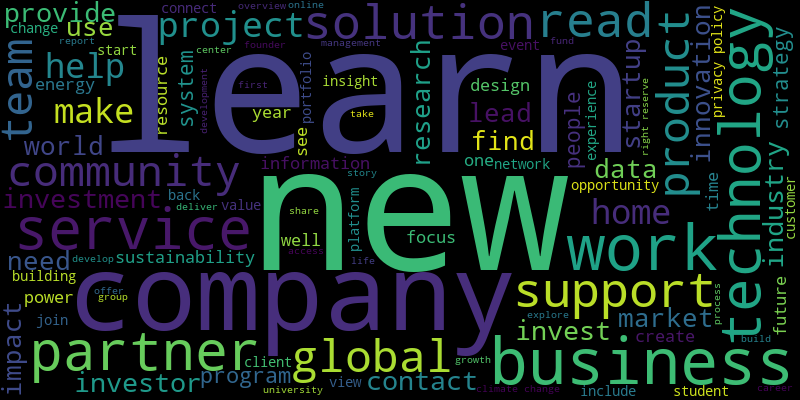

In [ ]:
from wordcloud import WordCloud

long_string = ','.join(list(english_only_df['text_cleaned_string'].values))

wordcloud = WordCloud(background_color='black', \
                      max_words = 100, \
                      contour_width = 3, \
                      contour_color = 'steelblue', \
                      width = 800, height = 400).generate(long_string)

wordcloud.to_image()

At this point, we can get rid of all the extra fields and come back to just our new, processed text. We also exported this as a CSV using the Pandas `to_csv()` function, which you can access [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-segmentation/main/english_cleaned_unique.csv).

In [ ]:
english_cleaned_unique_df = english_only_df[['url','text_cleaned_string']].rename(columns={'text_cleaned_string':'text'})
english_cleaned_unique_df

,url,text
0,cornell.edu,cornell university private research university...
2,ida.ie,look new home business look far ireland perfor...
3,tolacapital.com,tola capital company engagement team contact s...
4,hearst.com,home hearst navigation skip content hearstlife...
5,buchanan.uk.com,home buchanan uk close story people advisory b...
...,...,...
2835,corpgov.net,corporate governance navigation corporate gove...
2836,knoweatall.co,curating recipe preference kuri build personal...
2837,petri.bio,petri provide custom capital support connectio...
2838,climatescape.org,discover organization solve climate change cli...


In [ ]:
english_cleaned_unique_df.to_csv('english_cleaned_unique.csv')

However, there is one final step. We don't want websites that have a single instance overpowering websites that have several subscribers, so we re-join our dataset with our initial website list in order to account for frequency. Again, we exported this as a CSV using the Pandas `to_csv()` function, which you can access [here](https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/english_cleaned_all.csv).

In [ ]:
english_cleaned_all_df = websites_df.merge(english_cleaned_unique_df, left_on='Website', right_on='url', how= 'inner')
english_cleaned_all_df = english_cleaned_all_df[['url','text']]
english_cleaned_all_df

,url,text
0,cornell.edu,cornell university private research university...
1,cornell.edu,cornell university private research university...
2,cornell.edu,cornell university private research university...
3,cornell.edu,cornell university private research university...
4,cornell.edu,cornell university private research university...
...,...,...
3498,corpgov.net,corporate governance navigation corporate gove...
3499,knoweatall.co,curating recipe preference kuri build personal...
3500,petri.bio,petri provide custom capital support connectio...
3501,climatescape.org,discover organization solve climate change cli...


In [ ]:
english_cleaned_all_df.to_csv('english_cleaned_all.csv')

Interestingly, the word frequencies change drastically after we re-weight / allow for duplicate websites. Microsoft Outlook makes a heavy appearance here.

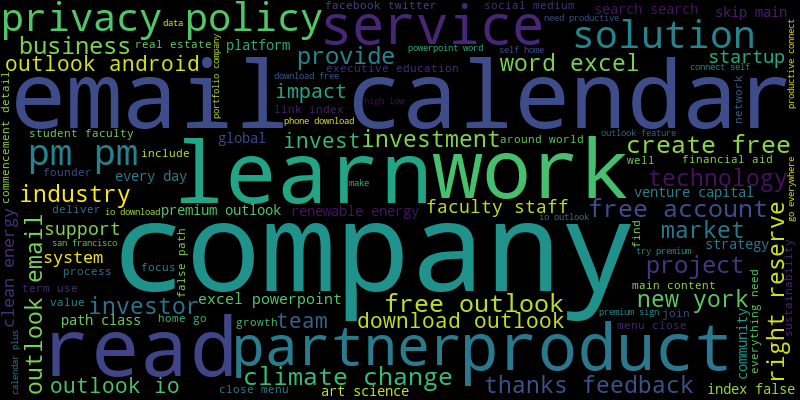

In [ ]:
from wordcloud import WordCloud

long_string = ','.join(list(english_cleaned_all_df['text'].values))

wordcloud = WordCloud(background_color='black', \
                      max_words = 100, \
                      contour_width = 3, \
                      contour_color = 'steelblue', \
                      width = 800, height = 400).generate(long_string)

wordcloud.to_image()

# Part 2: Clustering
---
With our new cleaned documents, we begin segmenting our readers with various methods. We first try K-Means clustering, and then we try Topic Modeling with Latent Dirchlet Allocation.

## 2.1 K-Means Clustering

The first thing that comes to mind when we consider clustering is K-Means clustering. Unfortunately, we can't directly compute Euclidean distance between words, so we need to conduct some feature engineering in order to conduct K-Means clustering.

We opted to use `TF-IDF` (or Term Frequency-Inverse Document Frequency) to compute the importance of a word in a corpus, with the most relevant terms being the most important. The more times a word appears within a document, the stronger that word is (hence Term Frequency), but the more documents the word appears in, the less unique / salient that word is (hence Inverse Document Frequency).


### 2.1.1 Selecting the Right Data
Because of the way Inverse Document Frequency works, it's best for us to use TF-IDF on our `english_cleaned_unique_df` dataframe, rather than dataframes that have high repeats. Otherwise, all words associated with Cornell University might be unfairly underweighted. Sorry, Cornell.

In [ ]:
english_cleaned_unique_df

,url,text
0,cornell.edu,cornell university private research university...
1,ida.ie,look new home business look far ireland perfor...
2,tolacapital.com,tola capital company engagement team contact s...
3,hearst.com,home hearst navigation skip content hearstlife...
4,buchanan.uk.com,home buchanan uk close story people advisory b...
...,...,...
1944,corpgov.net,corporate governance navigation corporate gove...
1945,knoweatall.co,curating recipe preference kuri build personal...
1946,petri.bio,petri provide custom capital support connectio...
1947,climatescape.org,discover organization solve climate change cli...


### 2.1.2 Computing TF-IDF

To compute TF-IDF, we use the sklearn TfidfVectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = english_cleaned_unique_df['text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
tf_idf.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948
cornell,0.737450,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.152607,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
ithaca,0.184727,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
university,0.175658,0.008493,0.0,0.0,0.0,0.0,0.0,0.169997,0.029416,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.092133,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002879,0.0,0.119719,0.116499,0.0,0.160157,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.035633,0.0,0.0,0.0,0.0,0.0,0.020699,0.0,0.0,0.0,0.0,0.0,0.0,0.008651,0.0,0.021595,0.0,0.0
slide,0.165428,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033558,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
student,0.137451,0.000000,0.0,0.0,0.0,0.0,0.0,0.101349,0.000000,0.0,0.0,0.007591,0.0,0.0,0.0,0.0,0.123588,0.0,0.004881,0.0,0.0,0.0,0.01827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021025,0.0,0.178435,0.121546,0.0,0.133676,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014008,0.0,0.0,0.0,0.0,0.0,0.0,0.031146,0.0,0.0,0.0,0.0,0.0,0.0,0.241650,0.0,0.0,0.0,0.0,0.0,0.129576,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [ ]:
tf_idf

,aa,aaa,aaac,aaavc,aachen,aachener,aacsb,aae,aakash,aaland,aalto,aamidor,aamir,aamodt,aan,aansturen,aantal,aapi,aarhus,aarkkariyam,aaron,aaronson,aarp,aarti,aarushi,aasha,aashirvaad,aave,aayush,ab,aba,ababa,ababax,aback,abacus,abajas,abalone,aban,abandon,abandonment,...,찾는,천명,최대,추구하는,캐피탈,테헤란로,통해,투자,투자가,투자기회를,투자를,투자섹터에서,투자시장의,투자의,투자자,투자자에게는,투자합니다,트렌드와,특히,패러다임을,포럼인,표준이,하는,한국,한국어,한국의,함께,해결을,해결하고자,헬스케어,혁신을,확장하고,환경,활동해,회사를,ﬁnancing,𝒂𝒓𝒆,𝒅𝒐,𝘔𝘢𝘳𝘬,𝘝𝘢𝘯𝘥𝘦𝘳𝘣𝘦𝘦𝘬𝘦𝘯
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note that in the end, we want to categorize each website with a cluster, so we will run k-means on tf_idf instead of its transpose. In the table above, each entry represents the tf-idf value of the word (the column) in the particular website (the row). 

**Note on TF and IDF:**
- Since idf value punishes the number of different websites a word has appeared in, the idf value for each word is the same across all websites. 
- Since the tf (term frequency) of each word is calculated by website and is thus different across websites. This is why each word will still have a different tf-idf value in each website.

### 2.1.3 Conducting K-Means

Now that we have the tf-idf values, we can calculate distance. This means we can categorize each website by the combination of the tf-idf values of every words.

The first step of k-means is to determine our `k`. To do this, we use the "elbow method" to see the change in the sum of squared distances as we increase the number of clusters.

In [ ]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(3,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=1)
    km = km.fit(tf_idf)
    Sum_of_squared_distances.append(km.inertia_)

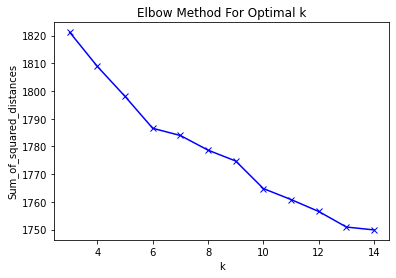

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We can see that the dip is around when k=13. We will use this value for our number of clusters and train our final k-means model, `km`.

In [ ]:
km = KMeans(n_clusters=13, random_state=1)
km = km.fit(tf_idf)

### 2.1.4 Visualizing K-Means

Now that we have our model, we'll want to do the following: 
1. Vizualize our K-Means clusters;
2. Create word clouds for our clusters; and
3. Try to label our clusters ourselves.

First, let's define some functions to extract the top words of each cluster (`get_top_features_cluster`) and vizualize those words with a barplot (`plotWords`).

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

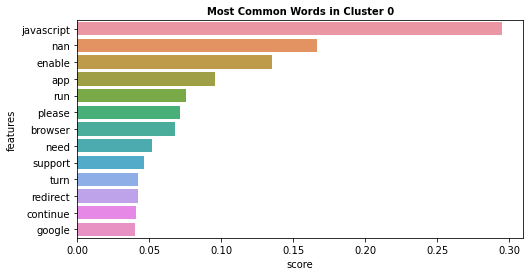

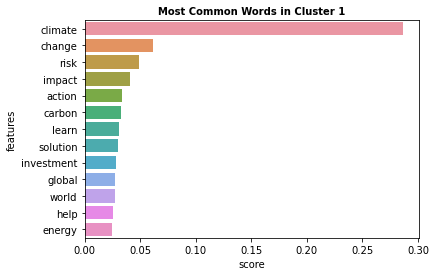

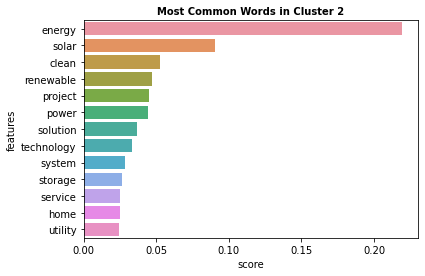

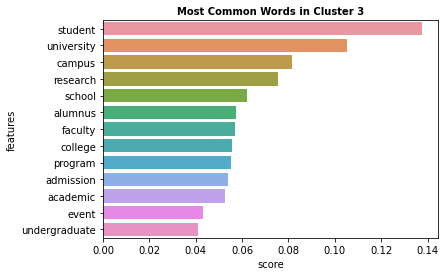

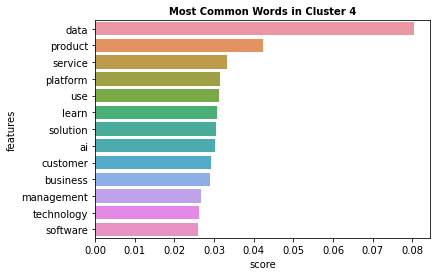

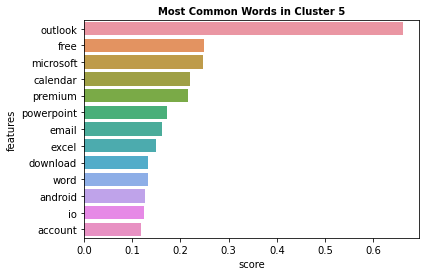

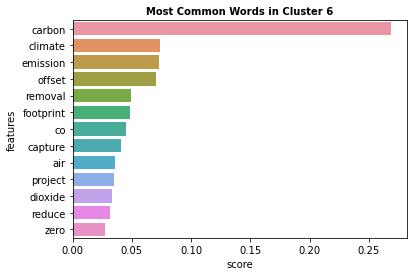

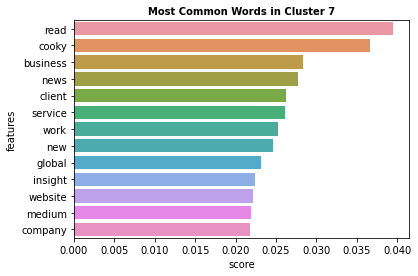

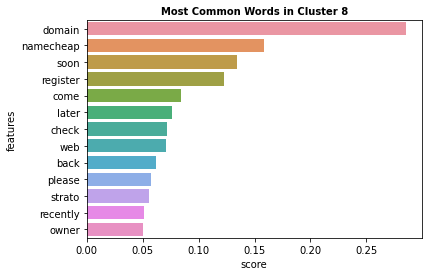

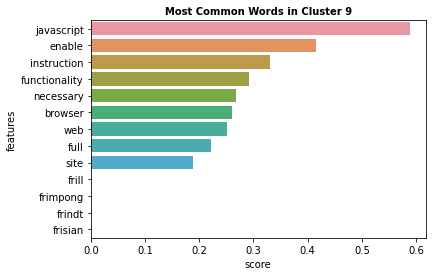

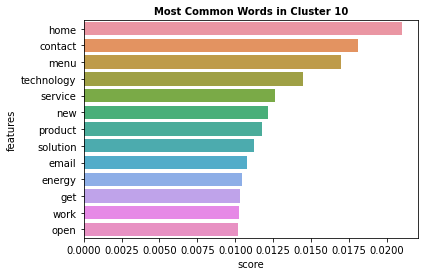

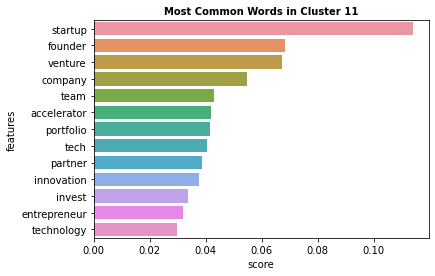

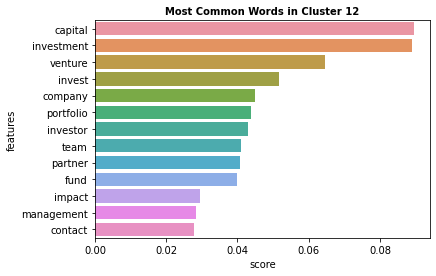

In [ ]:
final_df_array = tf_idf.to_numpy()
prediction = km.predict(final_df_array)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

We can see some very clear trends for words within given clusters. To further vizualize this we, use word clouds.

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)
        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

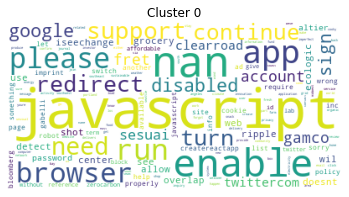

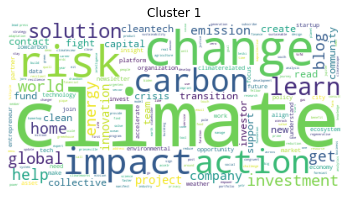

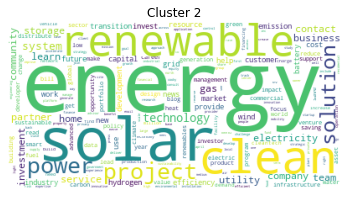

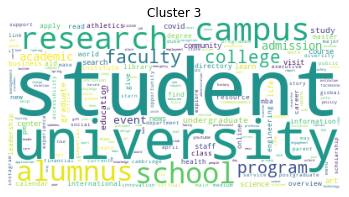

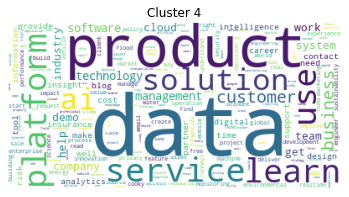

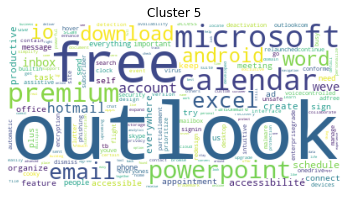

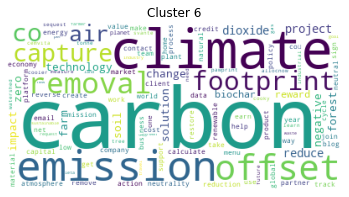

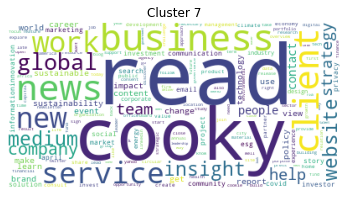

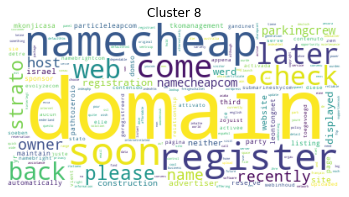

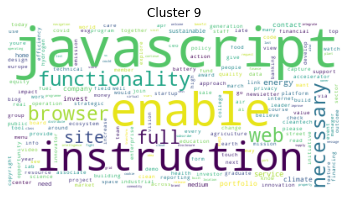

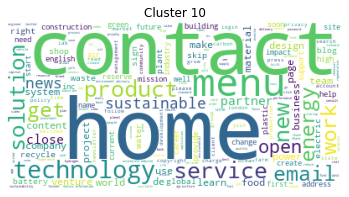

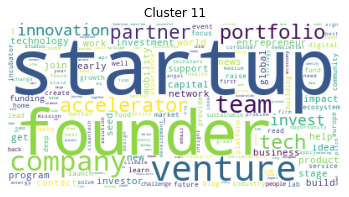

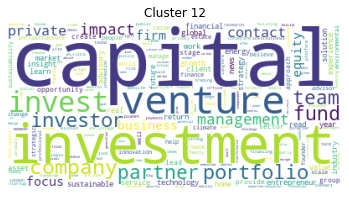

In [ ]:
centroids = pd.DataFrame(km.cluster_centers_)
centroids.columns = tf_idf.columns
generateWordClouds(centroids)

Here the patterns emerge. Based off the word clouds, these are our guesses.

| Cluster Number | Our Best Guess |
| --- | --- |
| 0 | Personal Emails (Gmail, Hotmail, Proton) |
| 1 | General Climate Groups |
| 2 | Energy|
| 3 | Students / Academia |
| 4 | AI / SaaS|
| 5 | Microsoft Outlook Users |
| 6 | Carbon Capture and Emissions Reduction |
| 7 | News Sites |
| 8 | Email Forwarding & Email-only Domains | 
| 9 | Random Bits of Javascript and HTML |
| 10 | Consumer Products / Consumer-Focused Businesses |
| 11 | Startup Accelerators / Startup Services |
| 12 | Venture Capital and Investments |







### 2.1.5 Putting K-Means to the Test

Now that we have our K-Means model, we use these trained assignments to assign each of our documents (each website) to one of these clusters.

In [ ]:
labels = km.labels_ 
english_cleaned_unique_df['label'] = labels
english_cleaned_unique_df.head()

,url,text,label
0,cornell.edu,cornell university private research university...,3
1,ida.ie,look new home business look far ireland perfor...,7
2,tolacapital.com,tola capital company engagement team contact s...,4
3,hearst.com,home hearst navigation skip content hearstlife...,10
4,buchanan.uk.com,home buchanan uk close story people advisory b...,7


In [ ]:
labled_english_all_df = english_cleaned_all_df.merge(english_cleaned_unique_df, how='left', on='url')
labled_english_all_df.drop(columns=['text_y'], inplace=True)
labled_english_all_df.rename(columns={'text_x':'text'}, inplace=True)
labled_english_all_df[labled_english_all_df['label']==12]

,url,text,label
30,prospediacapital.com,automotive investment funding venture capital ...,12
32,cppib.com,cpp investment global investment management or...,12
33,cppib.com,cpp investment global investment management or...,12
34,cppib.com,cpp investment global investment management or...,12
35,cppib.com,cpp investment global investment management or...,12
...,...,...,...
3415,longspur.com,home global specialist leader new energy clean...,12
3418,planetfirst.partners,purposedriven european growth investor well pe...,12
3430,lieef.com,sustainable investment firm focus emerge infra...,12
3488,starquest-capital.com,starquest capital team portfolio documentation...,12


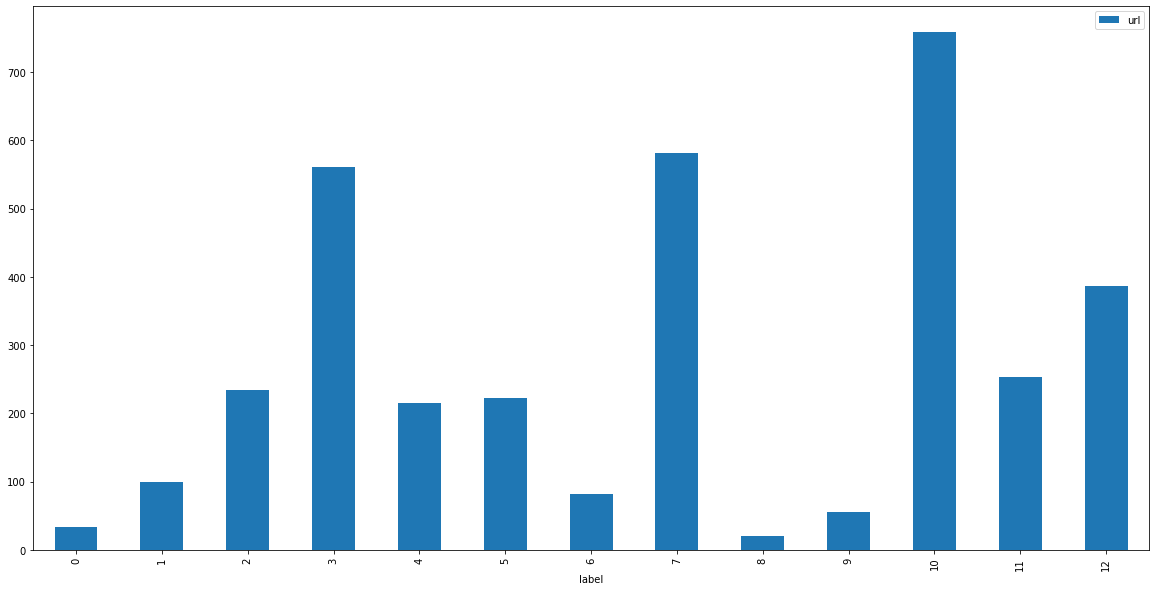

In [ ]:
distribution_df = labled_english_all_df.groupby(by='label').count().reset_index()
distribution_df.plot.bar(x='label', y='url', figsize=(20, 10))

We can see that cluster 3, 7, 10 and 12 are the most prominent clusters. If we look back to the most frequent words in each cluster, we can see that it makes sense those clusters are the most popular as cluster 3 are words associate with college, 7 are words associated with news, 10 are words associate with home, service or products and 12 are words associated with venture capitalism. They are in line with expected audience of our site.

### 2.1.6 Thoughts on K-Means

In general, we can see that our clusters are fairly acurate. In each cluster, we can see that the words are indeed coorelated to each other - suggesting that our metric - tf-idf - is a solid metric to calculate distance for k-means clusters. Using the final distribution of cluster, we can effectively center our marketing and newsletters to students and VCs with a focus on introducing new service and products, as well as providing news.


Overall, K-Means has a few distinct benefits as well as a few drawbacks. While K-Means clustering is a strong unsupervised learning method, traditional implementations are definitive / exclusive. That is to say, a given word or document is assigned to one cluster and one cluster only. Oftentimes, we'll find words that appear in multiple documents (especially words that might have different definitions depending on context). While K-Means is a strong solution for our particular problem, we explore a probabilistic approach using Latent Dirchlet Allocation.

## 2.2 Topic Modeling with Latent Dirichlet Allocation
---

In order to account for the fact that *not* all words fall nicely into one bucket or the other, and neither do companies, we can try a probabilistic approach to clustering, instead.

We find a potential solution in Latent Dirchlet Allocation (LDA). Without going to into depth (read more [here](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)), the LDA model effectively assumes the following:
1. Length of documents follow some Poisson distribution
2. Documents are a mixture of a fixed number of K "topics" that follows some Dirchelet distribution over those K topics.
3. Words have their own probability of being in each topic (so they can show up in multiple topics).
4. Thus, documents are functionally generated by having some random length, then generating documents by randomly pulling words from topics based off the assumed distribution of topics the document is based on.

### 2.2.1 Data Revisited

For LDA, words can fit in multiple topics, which means that we may want to remove words that appear too much. Instead of computing `TF-IDF` to do this, we instead seek to extract bigrams like "venture capital" and remove terms that might appear everywhere (i.e. company, email, etc.).

In [ ]:
# We exported our data before, so let's just read it in that way.
topic_modeling_df = pd.read_csv('https://raw.githubusercontent.com/YuDrew/strategic-subscriber-sorter/main/english_cleaned_unique.csv')
topic_modeling_df = topic_modeling_df[['url','text']].astype({'url':str,'text':str})
topic_modeling_df

,url,text
0,cornell.edu,cornell university private research university...
1,ida.ie,look new home business look far ireland perfor...
2,tolacapital.com,tola capital company engagement team contact s...
3,hearst.com,home hearst navigation skip content hearstlife...
4,buchanan.uk.com,home buchanan uk close story people advisory b...
...,...,...
1944,corpgov.net,corporate governance navigation corporate gove...
1945,knoweatall.co,curating recipe preference kuri build personal...
1946,petri.bio,petri provide custom capital support connectio...
1947,climatescape.org,discover organization solve climate change cli...


In [ ]:
#First up, we need to separate the text field into tokens
def doc_to_words(docs):
  for doc in docs:
    yield(gensim.utils.simple_preprocess(str(doc), deacc=True))

docs = topic_modeling_df.text.values.tolist()
docs = list(doc_to_words(docs))

We'll create bigrams in order to capture phrases like "venture capital" and "climate tech."

In [ ]:
from gensim.models import Phrases

# Add bigrams and trigrams to the docs
bigram = Phrases(docs, min_count = 20)
for index in range(len(docs)):
  for token in bigram[docs[index]]:
    if '_' in token:
      docs[index].append(token) #add bigram to document

Now, our docs should also have bigrams. 

In [ ]:
str(docs[0])

"['cornell', 'university', 'private', 'research', 'university', 'provide', 'exceptional', 'education', 'undergraduate', 'graduate', 'professional', 'student', 'cornell', 'college', 'school', 'encompass', 'field', 'study', 'location', 'ithaca', 'new', 'york', 'new', 'york', 'city', 'doha', 'qatar', 'cornell', 'university', 'skip', 'content', 'cornell', 'university', 'search', 'toggle', 'menu', 'close', 'cornell', 'cornell', 'overview', 'university', 'fact', 'map', 'direction', 'mission', 'vision', 'core', 'value', 'tradition', 'location', 'ithaca', 'new', 'york', 'city', 'related', 'link', 'diversity', 'economic', 'impact', 'sustainability', 'global', 'cornell', 'leadership', 'admission', 'overview', 'undergraduate', 'apply', 'admission', 'date', 'deadline', 'cost', 'aid', 'graduate', 'admission', 'field', 'study', 'financial', 'support', 'continue', 'education', 'summer', 'session', 'summer', 'session', 'winter', 'session', 'parttime', 'study', 'academic', 'academic', 'overview', 'fiel

At this point, we have several words that should be common across all documents, as well as words that only appear once or twice and never again. We remove those using the `gensim.corpora` `Dictionary` package.

In [ ]:
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=10, no_above=0.5)

And then lastly, let's check the overall features of our data again.

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5231
Number of documents: 1949


### 2.2.2 Finding the Ideal Topic Number

Now that we've organized our data, the next thing we need to do is make sure we choose the right number of topics.

First, we assign a few important variables that will be used for all our models (i.e. corpus and id2word)

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in docs] #our collection of texts
workers = 20,
passes = 10,
iterations = 50,
random_state = 1
temp = dictionary[0] # this makes sure our dictionary is implemented
id2word = dictionary.id2token

In [ ]:
def compute_coherence(k):
  lda_model = gensim.models.LdaMulticore(corpus = corpus, 
                                         id2word = id2word, 
                                         num_topics = k, 
                                         workers = 20,
                                         passes = 10,
                                         iterations = 50,
                                         random_state = 1)
  coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts = docs, dictionary = dictionary, coherence='c_v')
  return coherence_model_lda.get_coherence(), k

Given what we've learned from K-means clustering and the optimal 12 clusters, we can expect that there should be more than 5 topics but likely no more than 20. So we can use our function to search for topic count with the highest coherence.

In [ ]:
coherence_scores_df = pd.DataFrame(columns=['coherence_score','num_topics'])

In [ ]:
for num in range(5,20):
  coherence_score, num_topics = compute_coherence(num)
  temp_df = pd.DataFrame({'coherence_score': [coherence_score], 'num_topics': [num_topics]})
  coherence_scores_df = coherence_scores_df.append(temp_df)
#Let's See the Scores
coherence_scores_df

,coherence_score,num_topics
0,0.460092,5
0,0.461681,6
0,0.455975,7
0,0.456125,8
0,0.456207,9
0,0.475198,10
0,0.485013,11
0,0.486128,12
0,0.447969,13
0,0.459800,14


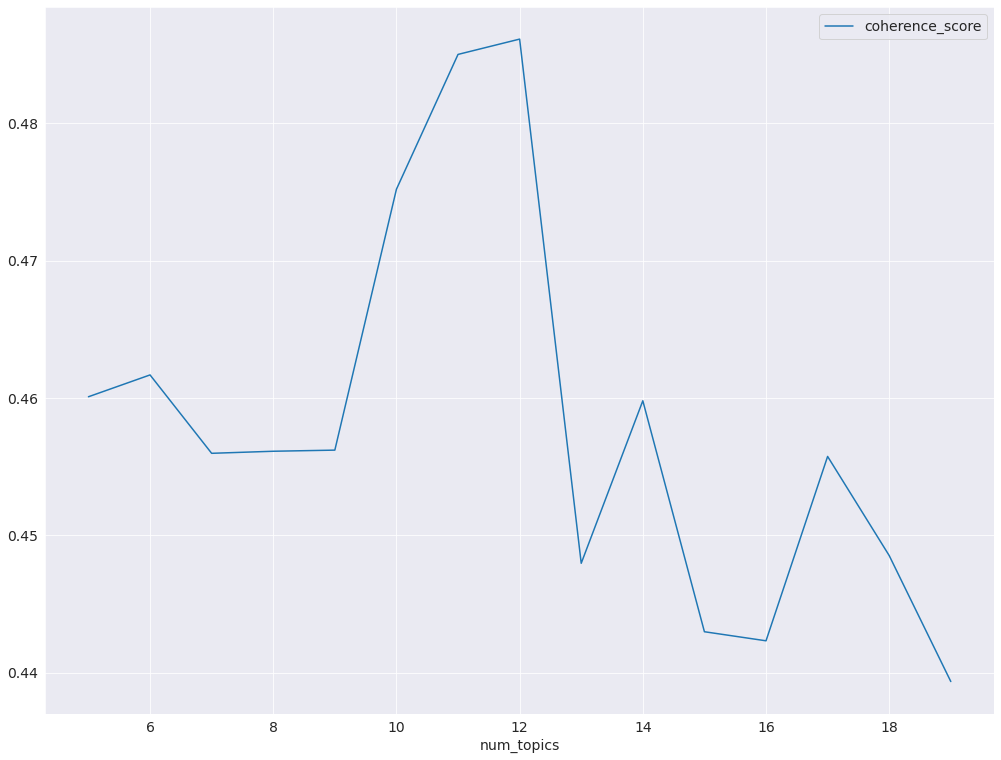

In [ ]:
coherence_scores_df.plot(x='num_topics', y='coherence_score',kind='line')

It seems like generally, maximum coherence is achieved at 12 topics as well, so we will also create 12 topics for our final model.

### 2.2.3 A 12-Topic LDA Model

With the data prepared, we can try running an LDA model to see if we can come up with salient topics. We've already set up important variables, so the only thing left is to run the model for 12 topics. 

In [ ]:
num_topics = 12 # We make this a separate code block in case results somehow change (they shouldn't)

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus = corpus, 
                                         id2word = id2word, 
                                         num_topics = num_topics, 
                                         workers = 20,
                                         passes = 10,
                                         iterations = 50,
                                         random_state = 1)

With the model run, we look at the topics put out by the model.

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"get" + 0.011*"service" + 0.010*"email" + 0.010*"use" + 0.009*"home" '
  '+ 0.008*"information" + 0.007*"address" + 0.006*"account" + '
  '0.006*"available" + 0.006*"plan"'),
 (1,
  '0.055*"climate" + 0.012*"change" + 0.011*"climate_change" + 0.008*"learn" + '
  '0.007*"solution" + 0.006*"read" + 0.006*"home" + 0.006*"air" + 0.006*"risk" '
  '+ 0.005*"help"'),
 (2,
  '0.049*"energy" + 0.013*"solar" + 0.012*"power" + 0.010*"project" + '
  '0.010*"solution" + 0.009*"technology" + 0.008*"clean" + 0.007*"system" + '
  '0.006*"renewable" + 0.006*"service"'),
 (3,
  '0.028*"cooky" + 0.017*"data" + 0.015*"website" + 0.014*"use" + '
  '0.011*"outlook" + 0.011*"email" + 0.009*"necessary" + 0.009*"free" + '
  '0.008*"enable" + 0.008*"browser"'),
 (4,
  '0.007*"food" + 0.007*"new" + 0.007*"make" + 0.006*"world" + 0.005*"help" + '
  '0.005*"sustainable" + 0.005*"product" + 0.005*"get" + 0.005*"change" + '
  '0.004*"business"'),
 (5,
  '0.014*"venture" + 0.013*"investment" + 0.013*"in

We can also calculate the coherence of the model.

In [ ]:
cm = gensim.models.CoherenceModel(model=lda_model, texts = docs, dictionary = dictionary, coherence = 'c_v')
coherence = (cm.get_coherence(), num_topics)
coherence

(0.4861282138859564, 12)

And we can visualize the topics with pyLDAvis.

In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.002565 -0.016096       1        1  14.370813
10     0.125805  0.121357       2        1  13.348868
5      0.000893 -0.052004       3        1  12.751078
6      0.026974 -0.064065       4        1  12.366120
2      0.020336 -0.108988       5        1  10.775507
0     -0.127873  0.059176       6        1   8.371058
4     -0.004718 -0.035000       7        1   8.277938
8     -0.027896 -0.087268       8        1   6.557393
1      0.005845 -0.081100       9        1   4.140667
3     -0.161944  0.130448      10        1   3.863607
11    -0.029456  0.039533      11        1   3.449451
7      0.174599  0.094007      12        1   1.727500, topic_info=          Term         Freq        Total Category  logprob  loglift
667     energy  4417.000000  4417.000000  Default  30.0000  30.0000
31     climate  2489.000000  2489.000000  Default  29.0000  29.0000
218    student  1809.000000  1809.000000  Default  28.0000  28.0000
315      cooky  1192.000000  1192.000000  Default  27.0000  27.0000
1877    carbon  1453.000000  1453.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
0     academic    43.500339   616.830178  Topic12  -5.5867   1.4067
183     public    43.195088   856.716689  Topic12  -5.5938   1.0711
131      learn    47.171473  3265.190716  Topic12  -5.5057  -0.1788
12       apply    40.174489   689.643033  Topic12  -5.6663   1.2156
263       year    39.370463  1559.011058  Topic12  -5.6865   0.3797

[903 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.008106  academic
0         2  0.867338  academic
0         3  0.011348  academic
0         4  0.019454  academic
0         5  0.001621  academic
...     ...       ...       ...
1483      8  0.489910      zero
1483      9  0.071116      zero
1483     10  0.011853      zero
1483     11  0.003951      zero
3445     11  0.946687  zimbabwe

[5115 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 11, 6, 7, 3, 1, 5, 9, 2, 4, 12, 8])

Many of the topics are actually very similar to the topics generated by K-Means. For example, Topic 2 is related to academia, and Topic 8 is mainly miscellaneous Javascript and login credentials. 

### 2.2.4 Segmentation Using LDA

Now that we have a model trained, we can use it to generate topic probability distributions for each website. For example, we can generate the probability of topics for Cornell University, shown below.

In [ ]:
test_doc = corpus[0]
vector = lda_model[test_doc]
print(docs[0])
print(vector)

['cornell', 'university', 'private', 'research', 'university', 'provide', 'exceptional', 'education', 'undergraduate', 'graduate', 'professional', 'student', 'cornell', 'college', 'school', 'encompass', 'field', 'study', 'location', 'ithaca', 'new', 'york', 'new', 'york', 'city', 'doha', 'qatar', 'cornell', 'university', 'skip', 'content', 'cornell', 'university', 'search', 'toggle', 'menu', 'close', 'cornell', 'cornell', 'overview', 'university', 'fact', 'map', 'direction', 'mission', 'vision', 'core', 'value', 'tradition', 'location', 'ithaca', 'new', 'york', 'city', 'related', 'link', 'diversity', 'economic', 'impact', 'sustainability', 'global', 'cornell', 'leadership', 'admission', 'overview', 'undergraduate', 'apply', 'admission', 'date', 'deadline', 'cost', 'aid', 'graduate', 'admission', 'field', 'study', 'financial', 'support', 'continue', 'education', 'summer', 'session', 'summer', 'session', 'winter', 'session', 'parttime', 'study', 'academic', 'academic', 'overview', 'field

Overall, the topics separated out by our LDA model are interesting but not as intuitive as in our K-Means clustering. As our objective is to make a tool that can be easily used by content-creators, K-Means clustering is a better bet.